In [1]:
################################################################################                                                                                                                                                              
################################################################################
#
# FILE: stadiums-description.ipynb
#
# BY: Dmitry Sedov 
#
# CREATED: Wed Aug 6 2020
#
# DESC: This code constructs a dataset with stadium properties:
#       * game count in 2018
#       * area
#       * sg visits
#       * attendance (if available)
#       * establishments within 5km
#
# EXEC:
#      
################################################################################
################################################################################

In [2]:
################################ Libraries #####################################

import sqlalchemy as db
import pandas as pd

import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

################################################################################

/home/user/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
################################# Options ######################################

pd.options.display.max_rows = 999

################################################################################

In [4]:
################################ Constants #####################################

year = 2018
project_folder = '/home/user/projects/stadiums'
output_folder = '/home/user/projects/stadiums/data/processed/descriptive'

################################################################################

In [5]:
############################## Common functions ################################

# Import total yearly visits
def import_visits(year, sport):
    """Read in the SG visits data for a sport."""
    
    search_query = f"""
    SELECT 
        s.sname_place_id AS sname_place_id,
        s.area_m2 AS area_m2,
        SUM(v.raw_visit_counts) AS stadium_visits
    FROM 
        stadiums AS s
    INNER JOIN
        visits AS v
    ON
        s.sname_place_id = v.sname_place_id
    AND
        v.year = {year}
    AND
        s.sport = '{sport}'
    GROUP BY
        s.sname_place_id, s.area_m2
    ;
    """
    
    results = pd.read_sql(search_query, con = engine)
    return results

# Import total establishment count close to stadiums (3km)
def import_establishments(sport):
    """Read in the nearby establishments data for a sport."""
    
    # PostgreSQL connection
    engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')
    
    create_temp_stadiums_table_with_geo = f"""
    CREATE TEMPORARY TABLE IF NOT EXISTS stadiums_with_geo AS
    SELECT
        sname_place_id,
        ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS s_location
    FROM
        stadiums
    WHERE 
        sport = '{sport}'
        ;

    CREATE INDEX IF NOT EXISTS stadiums_with_geo_sg_idx
    ON stadiums_with_geo (sname_place_id);

    CREATE INDEX IF NOT EXISTS stadiums_with_geo_location_idx
    ON stadiums_with_geo
    USING GIST(s_location);
    """
    
    create_temp_places_table_with_geo = f"""
    CREATE TEMPORARY TABLE IF NOT EXISTS places_with_geo AS
    SELECT
        sname_place_id,
        ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS p_location
    FROM
        establishments
    UNION
    SELECT
        sname_place_id,
        ST_SetSRID(ST_POINT(longitude, latitude), 4326)::geography AS p_location
    FROM
        restaurants
    ;
    CREATE INDEX IF NOT EXISTS places_with_geo_sg_idx
    ON places_with_geo (sname_place_id);

    CREATE INDEX IF NOT EXISTS places_with_geo_location_idx
    ON places_with_geo
    USING GIST(p_location);
    """
    
    with engine.connect() as connection:
        result = connection.execute(create_temp_stadiums_table_with_geo)

    with engine.connect() as connection:
        result = connection.execute(create_temp_places_table_with_geo)
    
    select_places_close_to_stadiums = """
    WITH joined_by_distance AS (
    SELECT
        p.sname_place_id AS place_id,
        s.sname_place_id AS stadium_id,
        ST_Distance(s.s_location, p.p_location) AS distance
    FROM
        stadiums_with_geo AS s
    LEFT JOIN
        places_with_geo AS p
    ON
        ST_DWithin(s.s_location, p.p_location, 3000)
    AND
        s.sname_place_id != p.sname_place_id )
    SELECT 
        stadium_id,
        COUNT(place_id) AS establishment_count
    FROM
        joined_by_distance
    GROUP BY 
        stadium_id
    ;
    """
    
    # Get the establishment count
    results = pd.read_sql(select_places_close_to_stadiums, con = engine)
    engine.dispose()
    
    return results

################################################################################

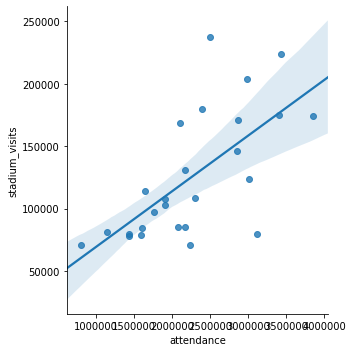

In [8]:
############################# Baseball stadiums ################################

# Set paths
teams_output_folder = os.path.join(project_folder, 'data/input/baseball/teams/')
games_output_folder = os.path.join(project_folder, 'data/input/baseball/games/')

# Import stadiums, capacity, matching of stadiums and sname place ids
stadiums = pd.read_csv(os.path.join(teams_output_folder,
                                    'baseball_teams.csv'),
                       usecols = ['name', 'code']
                      )

matching = pd.read_csv(os.path.join(teams_output_folder,
                                    'baseball_matching.csv')
                      )

capacity = pd.read_csv(os.path.join(teams_output_folder, 'baseball_locations.csv'), 
                       usecols = ['Team', 'Capacity'])
capacity.rename(columns = {'Team': 'name', 'Capacity': 'capacity'}, 
                inplace = True)

stadiums = pd.merge(stadiums, 
                    capacity,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums, 
                    matching,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums.set_index('code', inplace = True)

# Function to import game counts for each stadium
def import_game_count(year, code):
    """Read in and clean data for year-team."""
    # Set paths
    games_year_folder = os.path.join(games_output_folder, str(year))
    code_file_name = code + '_games.csv'
    year_code_file_path = os.path.join(games_year_folder, code_file_name)
    # Import
    data = pd.read_csv(year_code_file_path)
    # Filter for home games only
    mask = data['Unnamed: 4'].isnull()
    data = data[mask]
    # Get rid of double-dates
    data['Date'] = data['Date'].apply(lambda x: x.split('(')[0].strip())
    data.drop_duplicates(subset = ['Date'], inplace = True)
    # Format dates
    data['Date'] = (data['Date'].apply(lambda x: x.split(',')[1].strip()) + 
                    ' ' + data['year'].astype('str')
                   )
    data['Date'] = pd.to_datetime(data['Date'], format = '%b %d %Y')
    data['code'] = code
    game_count = data[['code', 'Attendance']
                     ].groupby('code').agg(['size',
                                            'sum'])
    return game_count


# Import game counts by stadiums, total attendance
games = [import_game_count(year, x) for x in stadiums.index]
games = pd.concat(games)
games.columns = ['games', 'attendance']
games['attendance'] = games['attendance'].astype('int64')

# Import visit counts by stadium
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')
visits = import_visits(year, 'baseball')
engine.dispose()

# Select stadiums only corresponding to the sample year
year_column = f'sg_id_{year}'
stadiums = stadiums[['name', 'capacity', year_column]]

# Import nearby establishment counts
nearby_establishments = import_establishments('baseball')

# Merge data
stadiums = pd.merge(stadiums,
                    games,
                    left_index = True, 
                    right_index = True, 
                    validate = 'one_to_one')
stadiums = pd.merge(stadiums,
                    visits,
                    how = 'inner',
                    left_on = year_column,
                    right_on = 'sname_place_id')
stadiums.drop(columns = year_column, inplace = True)
stadiums = pd.merge(stadiums,
                    nearby_establishments,
                    how = 'left',
                    left_on = 'sname_place_id',
                    right_on = 'stadium_id',
                    validate = 'one_to_one')
stadiums.drop(columns = 'sname_place_id', inplace = True)

baseball_stadiums = stadiums

# Plot official stadiums attendance vs SG visits
sns.lmplot(x = 'attendance', 
           y = 'stadium_visits',
           data = baseball_stadiums, 
           fit_reg = True)

################################################################################

In [10]:
baseball_stadiums.to_csv(path_or_buf = os.path.join(output_folder,
                                                    f'baseball_stadiums_summary_{year}.csv'), 
                         index = False)

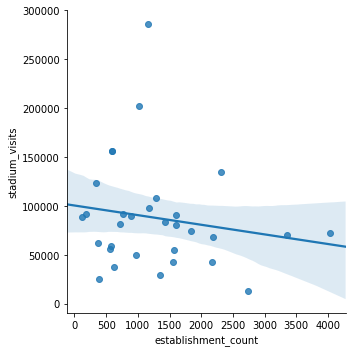

In [12]:
########################## Am. football stadiums ###############################

# Set paths
teams_output_folder = os.path.join(project_folder, 'data/input/football/teams/')
games_output_folder = os.path.join(project_folder, 'data/input/football/games/')

# Import stadiums, capacity, matching of stadiums and sname place ids
stadiums = pd.read_csv(os.path.join(teams_output_folder,
                                    'football_teams.csv'),
                       usecols = ['name', 'code']
                      )

matching = pd.read_csv(os.path.join(teams_output_folder,
                                    'football_matching.csv')
                      )

capacity = pd.read_csv(os.path.join(teams_output_folder, 'football_locations.csv'), 
                       usecols = ['Club', 'Capacity'])
capacity.rename(columns = {'Club': 'name', 'Capacity': 'capacity'}, 
                inplace = True)
# Replace broken team name
capacity.loc[capacity.name == 'San Francisco ers', 'name'] = 'San Francisco 49ers'

stadiums = pd.merge(stadiums, 
                    capacity,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums, 
                    matching,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums.set_index('code', inplace = True)

# Function to import game counts for each stadium
def import_game_count(year, code):
    """Read in and clean data for year-team."""

    # Set paths
    games_year_folder = os.path.join(games_output_folder, str(year))
    code_file_name_1 = code + '_season_games.csv'
    code_file_name_2 = code + '_playoff_games.csv'
    year_code_file_path_1 = os.path.join(games_year_folder, code_file_name_1)
    year_code_file_path_2 = os.path.join(games_year_folder, code_file_name_2)
    # Import
    data = pd.read_csv(year_code_file_path_1)
    if os.path.exists(year_code_file_path_2):
        data = data.append(pd.read_csv(year_code_file_path_2), ignore_index = True)
    # Filter for home games only
    mask = data['Unnamed: 6_level_1'].isnull()
    data = data[mask]
    # Format dates
    data['Date'] = (data['Date'] + 
                    ' ' + data['year'].astype('str')
                   )
    # Get rid of double-dates
    # data['Date'] = data['Date'].apply(lambda x: x.split('(')[0].strip())
    data.drop_duplicates(subset = ['Date'], inplace = True)
    
    data['Date'] = pd.to_datetime(data['Date'], format = '%B %d %Y')
    
    data['code'] = code
    
    # Return the game count by team
    data = data[['code']].groupby('code').size().to_frame('games')
    return data 


# Import game counts by stadiums, total attendance
games = [import_game_count(year, x) for x in stadiums.index]
games = pd.concat(games)

# Manual entry of games for playoff-participating teams
games.loc['nor'] += 1
games.loc['min'] += 2
games.loc['phi'] += 2
games.loc['ram'] += 1
games.loc['jax'] += 1
games.loc['kan'] += 1
games.loc['pit'] += 1
games.loc['nwe'] += 2


# Import visit counts by stadium
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')
visits = import_visits(year, 'football')
engine.dispose()

# Select stadiums only corresponding to the sample year
year_column = f'sg_id_{year}'
stadiums = stadiums[['name', 'capacity', year_column]]

# Import nearby establishment counts
nearby_establishments = import_establishments('football')

# Merge data
stadiums = pd.merge(stadiums,
                    games,
                    left_index = True, 
                    right_index = True, 
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums,
                    visits,
                    how = 'inner',
                    left_on = year_column,
                    right_on = 'sname_place_id')

stadiums.drop(columns = year_column, inplace = True)

# no one-to-one validation, NY shared stadium
stadiums = pd.merge(stadiums,
                    nearby_establishments,
                    how = 'left',
                    left_on = 'sname_place_id',
                    right_on = 'stadium_id')

stadiums.drop(columns = 'sname_place_id', inplace = True)

football_stadiums = stadiums

# Plot stadium visits vs establishment count
sns.lmplot(x = 'establishment_count', 
           y = 'stadium_visits',
           data = football_stadiums, 
           fit_reg = True)

################################################################################

In [14]:
football_stadiums.to_csv(path_or_buf = os.path.join(output_folder,
                                                    f'football_stadiums_summary_{year}.csv'), 
                         index = False)

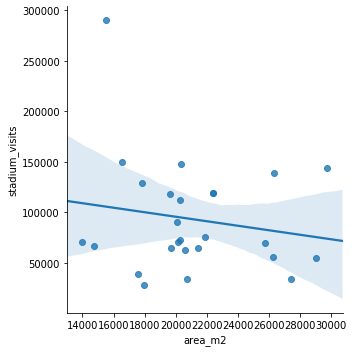

In [22]:
########################### Basketball stadiums ################################

# Set paths
teams_output_folder = os.path.join(project_folder, 'data/input/basketball/teams/')
games_output_folder = os.path.join(project_folder, 'data/input/basketball/games/')

# Import stadiums, matching of stadiums and sname place ids
stadiums = pd.read_csv(os.path.join(teams_output_folder,
                                    'basketball_teams.csv'),
                       usecols = ['name', 'code']
                      )

matching = pd.read_csv(os.path.join(teams_output_folder,
                                    'basketball_matching.csv')
                      )

capacity = pd.read_csv(os.path.join(teams_output_folder, 
                                    'basketball_locations.csv'), 
                       usecols = ['Team', 'Capacity'])
capacity.rename(columns = {'Team': 'name', 'Capacity': 'capacity'}, 
                inplace = True)

stadiums = pd.merge(stadiums, 
                    capacity,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums, 
                    matching,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums.set_index('code', inplace = True)

# Function to import game counts for each stadium
def import_game_count(year, code):
    """Read in and clean data for year-team."""
    
    # Set paths
    games_year_folder = os.path.join(games_output_folder, str(year))
    code_file_name_1 = code + '_season_games.csv'
    code_file_name_2 = code + '_playoff_games.csv'
    year_code_file_path_1 = os.path.join(games_year_folder, code_file_name_1)
    year_code_file_path_2 = os.path.join(games_year_folder, code_file_name_2)
    # Import
    data = pd.read_csv(year_code_file_path_1)
    if os.path.exists(year_code_file_path_2):
        data = data.append(pd.read_csv(year_code_file_path_2), ignore_index = True)
    # Filter for home games only
    mask = data['Unnamed: 5'].isnull()
    data = data[mask]
    data.drop_duplicates(subset = ['Date'], inplace = True)
    data['Date'] = pd.to_datetime(data['Date'], format = '%a, %b %d, %Y')
    
    data['code'] = code

    # Return the game count
    data = data[['code']].groupby('code').size().to_frame('games')
    return data 


# Import game counts by stadiums, total attendance
games = [import_game_count(year, x) for x in stadiums.index]
games = pd.concat(games)

# Import visit counts by stadium
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')
visits = import_visits(year, 'basketball')
engine.dispose()

# Select stadiums only corresponding to the sample year
year_column = f'sg_id_{year}'
stadiums = stadiums[['name', 'capacity', year_column]]

# Import nearby establishment counts
nearby_establishments = import_establishments('basketball')

# Merge data
stadiums = pd.merge(stadiums,
                    games,
                    left_index = True, 
                    right_index = True, 
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums,
                    visits,
                    how = 'inner',
                    left_on = year_column,
                    right_on = 'sname_place_id')

stadiums.drop(columns = year_column, inplace = True)

# Not one-to-one: lakers and clippers share a stadium
stadiums = pd.merge(stadiums,
                    nearby_establishments,
                    how = 'left',
                    left_on = 'sname_place_id',
                    right_on = 'stadium_id')

stadiums.drop(columns = 'sname_place_id', inplace = True)

basketball_stadiums = stadiums

# Plot stadium visits vs establishment count
sns.lmplot(x = 'area_m2', 
           y = 'stadium_visits',
           data = basketball_stadiums, 
           fit_reg = True)

################################################################################

In [24]:
basketball_stadiums.to_csv(path_or_buf = os.path.join(output_folder,
                                                      f'basketball_stadiums_summary_{year}.csv'), 
                         index = False)

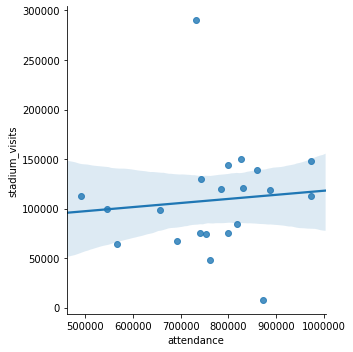

In [29]:
############################# Hockey stadiums ##################################

# Set paths
teams_output_folder = os.path.join(project_folder, 'data/input/hockey/teams/')
games_output_folder = os.path.join(project_folder, 'data/input/hockey/games/')

# Import stadiums, matching of stadiums and sname place ids
stadiums = pd.read_csv(os.path.join(teams_output_folder,
                                    'hockey_teams.csv'),
                       usecols = ['name', 'code']
                      )

matching = pd.read_csv(os.path.join(teams_output_folder,
                                    'hockey_matching.csv')
                      )
capacity = pd.read_csv(os.path.join(teams_output_folder, 
                                    'hockey_locations.csv'), 
                       usecols = ['Team', 'Capacity'])
capacity.rename(columns = {'Team': 'name', 'Capacity': 'capacity'}, 
                inplace = True)

# Replace broken team name, capacity fixed manually for NYI in the wiki file
capacity.loc[capacity.name == 'St Louis Blues', 'name'] = 'St. Louis Blues'

stadiums = pd.merge(stadiums, 
                    capacity,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums, 
                    matching,
                    on = 'name',
                    how = 'inner',
                    validate = 'one_to_one')

stadiums.set_index('code', inplace = True)

# Function to import game counts for each stadium
def import_game_count(year, code):
    """Read in and clean data for year-team."""
    # Set paths
    games_year_folder = os.path.join(games_output_folder, str(year))
    code_file_name_1 = code + '_season_games.csv'
    code_file_name_2 = code + '_playoff_games.csv'
    year_code_file_path_1 = os.path.join(games_year_folder, code_file_name_1)
    year_code_file_path_2 = os.path.join(games_year_folder, code_file_name_2)
    # Import
    data = pd.read_csv(year_code_file_path_1)
    if os.path.exists(year_code_file_path_2):
        data = data.append(pd.read_csv(year_code_file_path_2), ignore_index = True)
    # Filter for home games only
    mask = data['Unnamed: 2'].isnull()
    data = data[mask]
    # Get rid of double-dates
    data.drop_duplicates(subset = ['Date'], inplace = True)
    # Format dates 
    data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')
    data.rename(columns = {'Att.': 'Attendance'}, inplace = True)
    
    data['code'] = code

    # Return the game count
    game_count = data[['code', 'Attendance']
                     ].groupby('code').agg(['size',
                                            'sum'])
    return game_count 


# Import game counts by stadiums, total attendance
games = [import_game_count(year, x) for x in stadiums.index]
games = pd.concat(games)
games.columns = ['games', 'attendance']
games['attendance'] = games['attendance'].astype('int64')

# Import visit counts by stadium
engine = db.create_engine('postgresql://{user}:{user_pass}@{host}/{dataname2}')
visits = import_visits(year, 'hockey')
engine.dispose()

# Select stadiums only corresponding to the sample year
year_column = f'sg_id_{year}'
stadiums = stadiums[['name', 'capacity', year_column]]

# Import nearby establishment counts
nearby_establishments = import_establishments('hockey')

# Merge data
stadiums = pd.merge(stadiums,
                    games,
                    left_index = True, 
                    right_index = True, 
                    validate = 'one_to_one')

stadiums = pd.merge(stadiums,
                    visits,
                    how = 'inner',
                    left_on = year_column,
                    right_on = 'sname_place_id')

stadiums.drop(columns = year_column, inplace = True)

# One-to-one merge: no shared stadiums
stadiums = pd.merge(stadiums,
                    nearby_establishments,
                    how = 'left',
                    left_on = 'sname_place_id',
                    right_on = 'stadium_id', 
                    validate = 'one_to_one')

stadiums.drop(columns = 'sname_place_id', inplace = True)

hockey_stadiums = stadiums

# Plot stadium visits vs establishment count
sns.lmplot(x = 'attendance', 
           y = 'stadium_visits',
           data = hockey_stadiums, 
           fit_reg = True)

################################################################################

In [31]:
hockey_stadiums.to_csv(path_or_buf = os.path.join(output_folder,
                                                  f'hockey_stadiums_summary_{year}.csv'), 
                         index = False)